# Imports

In [46]:
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter
from scipy.stats import linregress


# Question 2: Generative Graph Models & Genetic Encodings

## Global Helpers

In [65]:
def generate_nodes(b):
    N = 2**b
    return [format(i, f'0{b}b') for i in range(N)]

def matches(node, pattern):    
    return all(p == 'X' or p == n for n, p in zip(node, pattern))

def get_indices(nodes, pattern):    
    return [idx for idx, node in enumerate(nodes) if matches(node, pattern)]


## Part 1

### Helpers

In [ ]:
def build_adjacency_matrix(b):
    nodes = generate_nodes(b)
    N = len(nodes)
    adj = np.zeros((N, N), dtype=int)
    for i in range(b + 1):
        Si = '0'*i + 'X'*(b-i)
        Di = 'X'*i + '1'*(b-i)
        sources = get_indices(nodes, Si)
        destinations = get_indices(nodes, Di)
        for s in sources:
            for d in destinations:
                adj[s, d] = 1
    return adj


In [61]:
def plot_degree_distribution(degrees, title):
    degrees = np.array(degrees)
    
    counts = Counter(degrees)
    k_values = np.array(list(counts.keys()))
    P_k = np.array(list(counts.values())) / len(degrees)      
    sorted_idx = np.argsort(k_values)
    k_values = k_values[sorted_idx]
    P_k = P_k[sorted_idx]
     
    plt.figure(figsize=(6,4))
    plt.loglog(k_values, P_k, 'o', markersize=4, label='Data')    
    log_x = np.log10(k_values)
    log_y = np.log10(P_k)
    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    
    plt.loglog(k_values, 10**intercept * k_values**slope, 'r--', label=f'Fit: slope={slope:.2f}')
    
    plt.title(title)
    plt.xlabel("Degree k")
    plt.ylabel("P(k)")
    plt.legend()
    plt.show()
    
    return slope


### Simulations

In [62]:
b = 10
adj_matrix = build_adjacency_matrix(b)
in_deg = np.sum(adj_matrix, axis=0)
out_deg = np.sum(adj_matrix, axis=1)

print(adj_matrix)
print(in_deg)
print(out_deg)



[[1 1 1 ... 1 1 1]
 [0 1 0 ... 1 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
[   1    2    1 ...    2    1 1024]
[1024  512  256 ...    1    1    1]


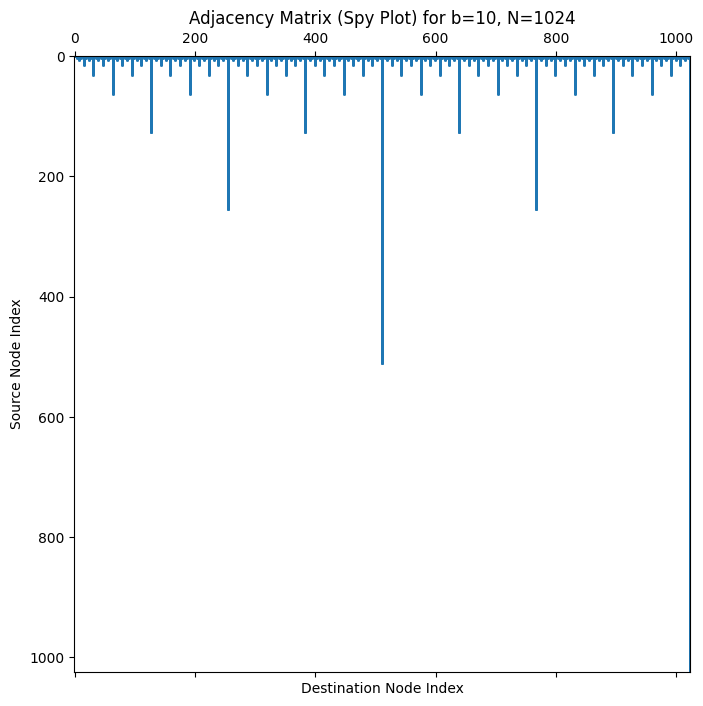

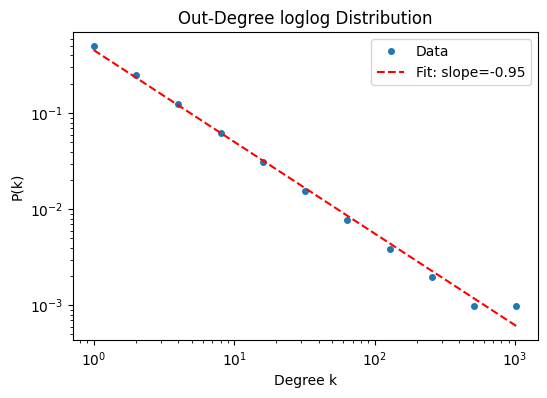

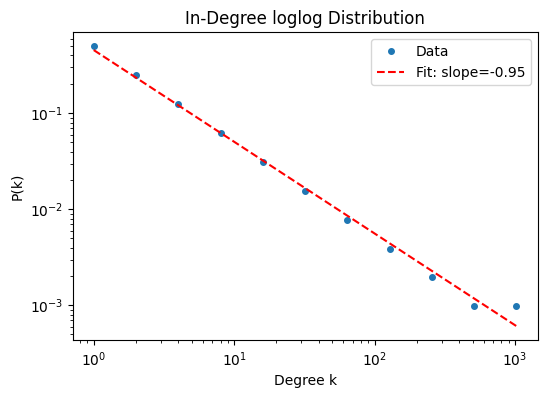

Estimated power-law exponent y (out-degree) ≈ 0.95
Estimated power-law exponent y (in-degree) ≈ 0.95


In [63]:
plt.figure(figsize=(8,8))
plt.spy(adj_matrix, markersize=1)
plt.title("Adjacency Matrix (Spy Plot) for b=10, N=1024")
plt.xlabel("Destination Node Index")
plt.ylabel("Source Node Index")
plt.show()

gamma_out = -plot_degree_distribution(out_deg, "Out-Degree loglog Distribution")
gamma_in = -plot_degree_distribution(in_deg, "In-Degree loglog Distribution")

print(f"Estimated power-law exponent y (out-degree) ≈ {gamma_out:.2f}")
print(f"Estimated power-law exponent y (in-degree) ≈ {gamma_in:.2f}")


## Part 2 

### Helpers

In [66]:

def random_pattern(b, x):
    positions = np.arange(b)
    X_positions = np.random.choice(positions, size=x, replace=False)
    pattern = ['0']*b
    for pos in X_positions:
        pattern[pos] = 'X'
    for i in range(b):
        if i not in X_positions:
            pattern[i] = random.choice(['0', '1'])
    return ''.join(pattern)

def random_genetic_network(b, x, r):
    nodes = generate_nodes(b)
    N = len(nodes)
    adj = np.zeros((N, N), dtype=int)
    
    for _ in range(r):
        S_pattern = random_pattern(b, x)
        D_pattern = random_pattern(b, x)
        
        sources = get_indices(nodes, S_pattern)
        destinations = get_indices(nodes, D_pattern)
        
        for s in sources:
            for d in destinations:
                adj[s, d] = 1
                
    return adj

def network_density(adj):
    return np.sum(adj) / adj.size


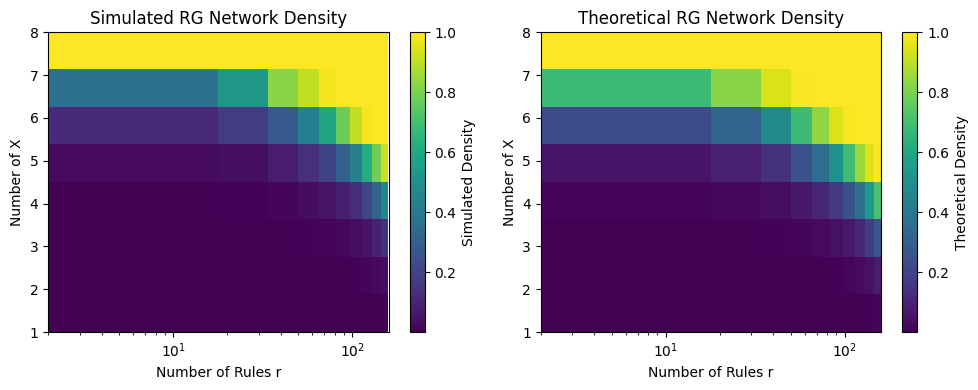

In [72]:

b = 8
x_values = np.arange(1, 9)
r_values = np.unique(np.round(np.logspace(np.log10(2), np.log10(160), 10)).astype(int))
density_matrix = np.zeros((len(x_values), len(r_values)))
theoretical_density = np.zeros_like(density_matrix)

for i, x in enumerate(x_values):
    pi = 2.0**(x - b)
    for j, r in enumerate(r_values):
        theoretical_density[i,j] = 1 - (1 - pi**2)**(2*r)

for i, x in enumerate(x_values):
    for j, r in enumerate(r_values):
        adj = random_genetic_network(b, x, r)
        density_matrix[i,j] = network_density(adj)

# Heatmap
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(density_matrix, origin='lower', aspect='auto',
           extent=[r_values[0], r_values[-1], x_values[0], x_values[-1]],
           cmap='viridis')
plt.colorbar(label='Simulated Density')
plt.title("Simulated RG Network Density")
plt.xlabel("Number of Rules r")
plt.ylabel("Number of X")
plt.xscale('log')

plt.subplot(1,2,2)
plt.imshow(theoretical_density, origin='lower', aspect='auto',
           extent=[r_values[0], r_values[-1], x_values[0], x_values[-1]],
           cmap='viridis')
plt.colorbar(label='Theoretical Density')
plt.title("Theoretical RG Network Density")
plt.xlabel("Number of Rules r")
plt.ylabel("Number of X")
plt.xscale('log')

plt.tight_layout()
plt.show()
